# Определение возраста покупателей

## Исследовательский анализ данных

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

    Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
    
    Контролировать добросовестность кассиров при продаже алкоголя.
    
    
Необходимо построить модель, которая по фотографии определит приблизительный возраст

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
labels.shape



Found 7591 validated image filenames.


(7591, 2)

array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

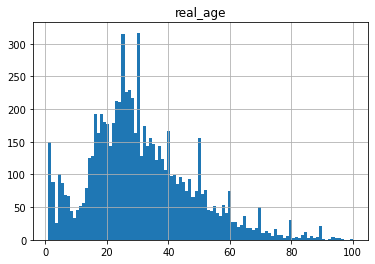

In [2]:
labels.hist(bins=100)

In [3]:
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


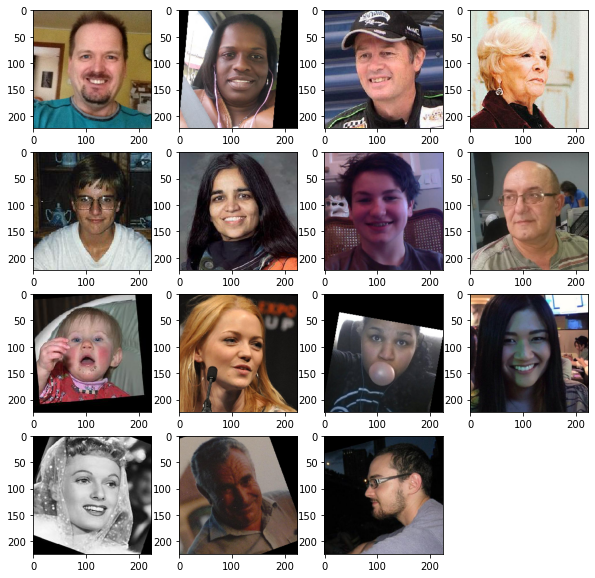

In [4]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])

### Вывод
В датасет с фотографими в котором  имеется 7591 фотография и csv-файл с 7591 записью, где имеется 2 колонки: название файла и возраст покупателя.
Исходя из описания датасета видно что, средний возраст покупателя составляет 31 год. В первый квартиль входят покупатели до 20 лет. Половину выборки составляют покупатели в возрасте до 29 лет, и 3/4 выборки - покупатели до 41 года.
Это говорит о том, то основную массу покупателей составляют люди от 20 до 41 года.
Для оценки качества фотографий напечатали 15 шт из датасета. Заметно, что фотографии имеют отконения по оси. Ориентацию части фотографий нужно привести к горизонтальной. Изображения отличаются размерами. На некоторых фотографиях лица повернуты, лица частично закрыты руками или предметами. Имеются черно-белые фотографии     в что усложняет обучение модели.

## Обучение модели

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf




def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True,  rescale=1. / 255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=30,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model



In [ ]:
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/30
356/356 - 48s - loss: 207.5043 - mae: 10.3679 - val_loss: 446.1080 - val_mae: 15.9563
Epoch 2/30
356/356 - 39s - loss: 83.2656 - mae: 6.8913 - val_loss: 135.0596 - val_mae: 8.7617
Epoch 3/30
356/356 - 39s - loss: 61.7804 - mae: 5.9678 - val_loss: 75.0485 - val_mae: 6.4971
Epoch 4/30
356/356 - 39s - loss: 43.0634 - mae: 5.0233 - val_loss: 94.1841 - val_mae: 7.2330
Epoch 5/30
356/356 - 39s - loss: 34.3067 - mae: 4.5056 - val_loss: 97.3854 - val_mae: 7.2877
Epoch 6/30
356/356 - 39s - loss: 27.0781 - mae: 3.9694 - val_loss: 71.1181 - val_mae: 6.3053
Epoch 7/30
356/356 - 39s - loss: 20.0293 - mae: 3.4376 - val_loss: 76.9178 - val_mae: 6.8150
Epoch 8/30
356/356 - 39s - loss: 15.7009 - mae: 3.0162 - val_loss: 67.9989 - val_mae: 6.0996
Epoch 9/30
356/356 - 39s - loss: 14.6134 - mae: 2.9033 - val_loss: 67.4531 - val_mae: 6.0944
Epoch 10/30
356/356 - 39s - loss: 12.8513 - mae: 2.7189 - val_loss: 68.5910 - val_mae: 6.2645
Epoch 11/30
356/356 - 39s - loss: 11.4770 - mae: 2.5709 - val_loss: 65.7391 - val_mae: 6.0736
Epoch 12/30
356/356 - 39s - loss: 12.7822 - mae: 2.7142 - val_loss: 66.3812 - val_mae: 6.0420
Epoch 13/30
356/356 - 39s - loss: 13.1108 - mae: 2.7546 - val_loss: 75.0946 - val_mae: 6.4667
Epoch 14/30
356/356 - 39s - loss: 11.9137 - mae: 2.6327 - val_loss: 65.9309 - val_mae: 6.1644
Epoch 15/30
356/356 - 39s - loss: 10.4026 - mae: 2.4586 - val_loss: 77.0869 - val_mae: 6.7769
Epoch 16/30
356/356 - 39s - loss: 10.2025 - mae: 2.4191 - val_loss: 64.5713 - val_mae: 5.8923
Epoch 17/30
356/356 - 39s - loss: 9.4684 - mae: 2.3232 - val_loss: 66.9205 - val_mae: 6.0909
Epoch 18/30
356/356 - 39s - loss: 10.1502 - mae: 2.4201 - val_loss: 61.2088 - val_mae: 5.8232
Epoch 19/30
356/356 - 39s - loss: 9.4253 - mae: 2.3471 - val_loss: 65.1151 - val_mae: 5.9932
Epoch 20/30
356/356 - 39s - loss: 9.0268 - mae: 2.2818 - val_loss: 62.8482 - val_mae: 5.9118
Epoch 21/30
356/356 - 39s - loss: 9.3158 - mae: 2.3262 - val_loss: 67.3731 - val_mae: 6.0134
Epoch 22/30
356/356 - 39s - loss: 8.5347 - mae: 2.2195 - val_loss: 72.4382 - val_mae: 6.2706
Epoch 23/30
356/356 - 39s - loss: 7.6149 - mae: 2.0918 - val_loss: 62.9875 - val_mae: 5.8112
Epoch 24/30
356/356 - 39s - loss: 6.9766 - mae: 2.0078 - val_loss: 60.0553 - val_mae: 5.7005
Epoch 25/30
356/356 - 39s - loss: 6.5380 - mae: 1.9437 - val_loss: 60.3704 - val_mae: 5.7235
Epoch 26/30
356/356 - 39s - loss: 6.9345 - mae: 2.0039 - val_loss: 60.5812 - val_mae: 5.7025
Epoch 27/30
356/356 - 39s - loss: 7.0132 - mae: 1.9904 - val_loss: 73.0195 - val_mae: 6.6523
Epoch 28/30
356/356 - 39s - loss: 7.1824 - mae: 2.0199 - val_loss: 65.2388 - val_mae: 5.9648
Epoch 29/30
356/356 - 39s - loss: 6.5121 - mae: 1.9340 - val_loss: 60.8004 - val_mae: 5.7908
Epoch 30/30
356/356 - 39s - loss: 6.4356 - mae: 1.9042 - val_loss: 57.6760 - val_mae: 5.5757

119/119 - 10s - loss: 57.6760 - mae: 5.5757
Test MAE: 5.5757

### Вывод

Для обучения модели использовали сверточную нейронную сеть - ResNet50
За 30 эпох нам удалось уменьшить МАЕ с 10 до 1.9 на тренировочной выборке. Тестовое МАЕ равняется 5.57 и значит что модель показывает хорошие результаты. 

## Анализ обученной модели

Обуенная модель показыват отличные результаты в определении возраста покупателей. Полученное тестовое значение МАЕ - 5.57 готоворит о том, что модель определет покупателей  в среднем с погрешностью в 6 лет. Это хороший результат модели, тк обычно сегментируют категории покупателей по 9-12 лет

Для построения модели мы использовали: 

    фреймворк - Tensorflow с высокоуровневым API - Keras;
    
    сверточную нейронную сеть ResNet-50,которая имеет 50 основных слоев (сверточные + полносвязные); 
    
     GlobalAveragePooling2D который применяет средний пул к пространственным измерениям до тех пор, пока каждое пространственное измерение не станет единым;
     
     Алгоритм Adam - подбирает различные параметры для разных нейронов, что также ускоряет обучение модели.
     
Использование GPU и нейронных сетей позволяет быстро и эффективно обработать большое количество информации с высокой точностью.

Данноe решение поможет бизнессу увеличить продажи товаров и контролировать продавцем при меньших затратах, то приведет к макимизации прибыли